The goal of this notebook is to test the following hypothesis: 

    library complexity is confounded with biology and removing library complexity removes biology
    
Narrowing it down, for the RA low input T cells and fibroblasts: 

    Forcing T cells and fibroblasts to have equal nUMI 
    

Possible directions: 

    1) simulated data 
    2) Why does sctransform kill THY1 signal in RA donor? Does local Poisson keep it? 
    3) AMP T cells and fibroblasts. They have such different library complexities. 
    

In [60]:
library(tidyverse)
library(data.table)
library(magrittr)
library(ggridges)
library(ggthemes)
library(harmony)
library(singlecellmethods)
library(ggrepel)
library(Matrix)
library(patchwork)
library(wilcoxauc)
library(sctransform)
library(scales)
library(uwot)
library(pheatmap)


In [42]:
# fig.size <- function (height, width) {
#     options(repr.plot.height = height, repr.plot.width = width)
# }


# do_scatter <- function(umap_use, meta_data, label_name, no_guides = TRUE, do_labels = TRUE, nice_names, palette_use,
#                        pt_size = 4, point_size = .5, base_size = 12, do_points = TRUE, do_density = FALSE, h = 6, w = 8) {
#     plt_df <- umap_use %>% data.frame() %>% 
#         cbind(meta_data) %>% 
#         dplyr::sample_frac(1L) 
#     plt_df$given_name <- plt_df[[label_name]]
    
#     if (!missing(nice_names)) {
#         plt_df %<>%
#             dplyr::inner_join(nice_names, by = "given_name") %>% 
#             subset(nice_name != "" & !is.na(nice_name))

#         plt_df[[label_name]] <- plt_df$nice_name        
#     }
        
#     plt <- plt_df %>% 
#         ggplot(aes_string("X1", "X2", col = label_name, fill = label_name)) + 
# #         theme_tufte(base_size = base_size) + 
#         theme_test(base_size = base_size) + 
#         theme(panel.background = element_rect(fill = NA, color = "black")) + 
#         guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = FALSE) +
#         scale_color_manual(values = palette_use) + 
#         scale_fill_manual(values = palette_use) +    
#         theme(plot.title = element_text(hjust = .5)) + 
#         labs(x = "UMAP 1", y = "UMAP 2") 
    
#     if (do_points) 
# #         plt <- plt + geom_point_rast(dpi = 300, width = w, height = h, size = point_size) 
#         plt <- plt + geom_point(shape = '.')
#     if (do_density) 
#         plt <- plt + geom_density_2d()    
        

#     if (no_guides)
#         plt <- plt + guides(col = FALSE, fill = FALSE, alpha = FALSE)
    
#     if (do_labels) 
#         plt <- plt + geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = label_name], label.size = NA,
#                                       aes_string(label = label_name), color = "white", size = pt_size, alpha = 1, segment.size = 0) + 
#         guides(col = FALSE, fill = FALSE)
#     return(plt)
# }


source('utils.R')

# Cell types have different nUMIs

In [4]:
data <- readRDS("/data/srlab/ik936/Foxxy/data/cache_pbmc_5p.rds")
exprs_raw <- data$exprs_raw


In [5]:
meta_data <- fread('/data/srlab/ik936/harmony_paper/PBMC_full/data/meta_data_subtypes.csv') %>% 
    data.frame()
row.names(meta_data) <- meta_data$cell_id
meta_data <- meta_data[colnames(exprs_raw), ]
meta_data %>% head


,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
fivePrime_AAACCTGAGCGATAGC,fivePrime_AAACCTGAGCGATAGC,fivePrime,2712,1318,0.06637168,nk,9,nk
fivePrime_AAACCTGAGCTAAACA,fivePrime_AAACCTGAGCTAAACA,fivePrime,6561,2164,0.05654626,mono,0,mono14
fivePrime_AAACCTGAGGGAGTAA,fivePrime_AAACCTGAGGGAGTAA,fivePrime,6322,2112,0.05615312,mono,0,mono14
fivePrime_AAACCTGAGTCTTGCA,fivePrime_AAACCTGAGTCTTGCA,fivePrime,4528,1526,0.07199647,tcells,11,cd8eff
fivePrime_AAACCTGAGTTCGATC,fivePrime_AAACCTGAGTTCGATC,fivePrime,3426,1332,0.06830123,mono,0,mono14
fivePrime_AAACCTGCACACTGCG,fivePrime_AAACCTGCACACTGCG,fivePrime,6199,1998,0.05097596,bcells,8,bmem


In [263]:
data.table(meta_data)[cell_subtype != ''][, median_numi := as.numeric(median(nUMI)), by = cell_subtype] %>% str

Classes ‘data.table’ and 'data.frame':	7469 obs. of  10 variables:
 $ cell_id     : chr  "fivePrime_AAACCTGAGCGATAGC" "fivePrime_AAACCTGAGCTAAACA" "fivePrime_AAACCTGAGGGAGTAA" "fivePrime_AAACCTGAGTCTTGCA" ...
 $ donor       : chr  "fivePrime" "fivePrime" "fivePrime" "fivePrime" ...
 $ nUMI        : int  2712 6561 6322 4528 3426 6199 2378 4934 3654 12842 ...
 $ nGene       : int  1318 2164 2112 1526 1332 1998 868 1571 1265 3159 ...
 $ percent_mito: num  0.0664 0.0565 0.0562 0.072 0.0683 ...
 $ cell_type   : chr  "nk" "mono" "mono" "tcells" ...
 $ res_0.80    : int  9 0 0 11 0 8 1 1 3 0 ...
 $ cell_subtype: chr  "nk" "mono14" "mono14" "cd8eff" ...
 $ depth       : num  7.91 8.79 8.75 8.42 8.14 ...
 $ median_numi : num  4112 4262 4262 4532 4262 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Picking joint bandwidth of 0.0437
Picking joint bandwidth of 146


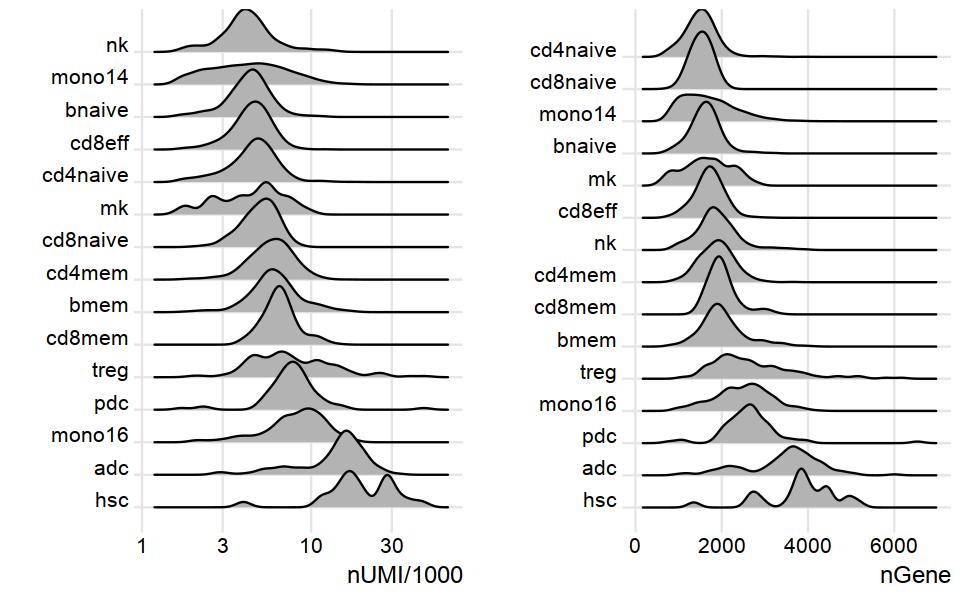

In [262]:
fig.size(5, 8)
data.table(meta_data)[cell_subtype != ''][, median_numi := as.numeric(median(nUMI)), by = cell_subtype] %>% 
    ggplot(aes(y = reorder(cell_subtype, -median_numi), x = nUMI / 1e3)) + 
        geom_density_ridges() + 
        scale_x_log10() + 
        theme_ridges() + 
        labs(y = '') + 
data.table(meta_data)[cell_subtype != ''][, median_numi := as.numeric(median(nGene)), by = cell_subtype] %>% 
    ggplot(aes(y = reorder(cell_subtype, -median_numi), x = nGene)) + 
        geom_density_ridges() + 
#         scale_x_log10() + 
        theme_ridges() + 
        labs(y = '') + 
NULL

In [7]:
with(meta_data, table(cell_subtype))

cell_subtype
              adc     bmem   bnaive   cd4mem cd4naive   cd8eff   cd8mem 
     228      124      429      747      868     1109      551      240 
cd8naive      hsc       mk   mono14   mono16       nk      pdc     treg 
     254       23       49     2248      330      304       74      119 

## Are we just looking at doublets? 

# Can we believe median fold change between cell types for raw UMIs? 

## Focus on dendritic cells

    Yuriy: flow sorted data can tell us what should be truly differentially expressed between cell types. 

In [8]:
meta_sub <- meta_data %>% 
#     subset(cell_subtype %in% c('cd4naive', 'cd4mem')) %>% 
    subset(cell_subtype %in% c('adc', 'pdc')) %>% 
#     dplyr::group_by(cell_subtype) %>% 
#     dplyr::sample_n(124, FALSE) %>% 
#     dplyr::ungroup()
    identity()
# exprs_sub <- log1p(exprs_raw[, meta_sub$cell_id])
exprs_sub <- (exprs_raw[, meta_sub$cell_id])
table(meta_sub$cell_subtype)



adc pdc 
124  74 

In [9]:
x <- split(seq_len(nrow(meta_sub)), meta_sub$cell_subtype) %>% lapply(function(idx) {
    apply(exprs_sub[, idx], 1, median)    
}) 
names(x) <- unique(meta_sub$cell_subtype)
x <- Reduce(cbind, x) %>% data.frame() %>%
    tibble::rownames_to_column('gene') 
colnames(x) <- c('gene', 'cDC', 'pDC')

x %>% 
    subset(gene %in% c('JCHAIN', 'FCER1A'))

,gene,cDC,pDC
2101,FCER1A,13,1
7685,JCHAIN,0,13


Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

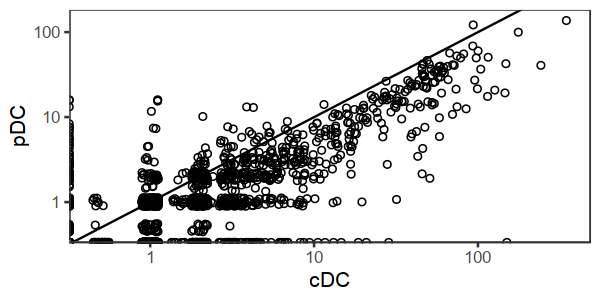

In [10]:
fig.size(2.5, 5)
x %>% 
    ggplot(aes(cDC, pDC)) + 
        scale_x_log10() + 
        scale_y_log10() + 
        geom_jitter(shape = 21, width = .05, height = .05) + 
        theme_test(base_size = 12) + 
        geom_abline(slope = 1, intercept = 0)

# Downstream effect of normalization

## Decide on HVGs

For now, just use the standard CPM pipeline

In [11]:
head(meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
fivePrime_AAACCTGAGCGATAGC,fivePrime_AAACCTGAGCGATAGC,fivePrime,2712,1318,0.06637168,nk,9,nk
fivePrime_AAACCTGAGCTAAACA,fivePrime_AAACCTGAGCTAAACA,fivePrime,6561,2164,0.05654626,mono,0,mono14
fivePrime_AAACCTGAGGGAGTAA,fivePrime_AAACCTGAGGGAGTAA,fivePrime,6322,2112,0.05615312,mono,0,mono14
fivePrime_AAACCTGAGTCTTGCA,fivePrime_AAACCTGAGTCTTGCA,fivePrime,4528,1526,0.07199647,tcells,11,cd8eff
fivePrime_AAACCTGAGTTCGATC,fivePrime_AAACCTGAGTTCGATC,fivePrime,3426,1332,0.06830123,mono,0,mono14
fivePrime_AAACCTGCACACTGCG,fivePrime_AAACCTGCACACTGCG,fivePrime,6199,1998,0.05097596,bcells,8,bmem


In [14]:
library(singlecellmethods)
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% normalizeData(method = 'log')
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, rep('A', nrow(meta_data)))
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 2000), by = group][, symbol])
message(length(var_genes))


2000


## Raw: log(UMI)

In [24]:
pca_res <- exprs_raw[var_genes, ] %>% 
    log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V1 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [25]:
umap1 <- umap(V1, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

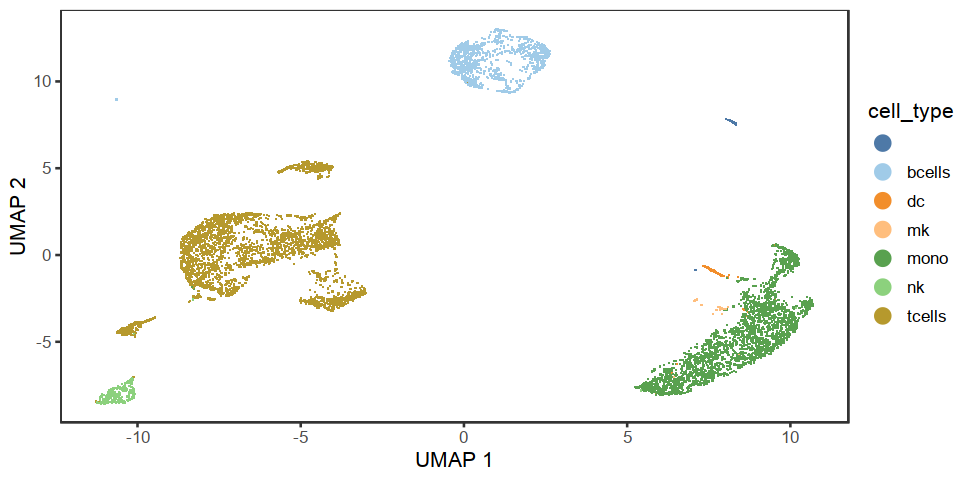

In [260]:
fig.size(4, 8)
do_scatter(umap1, meta_data, "cell_type", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

## log(CPM)

In [27]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V2 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [28]:
umap2 <- umap(V2, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

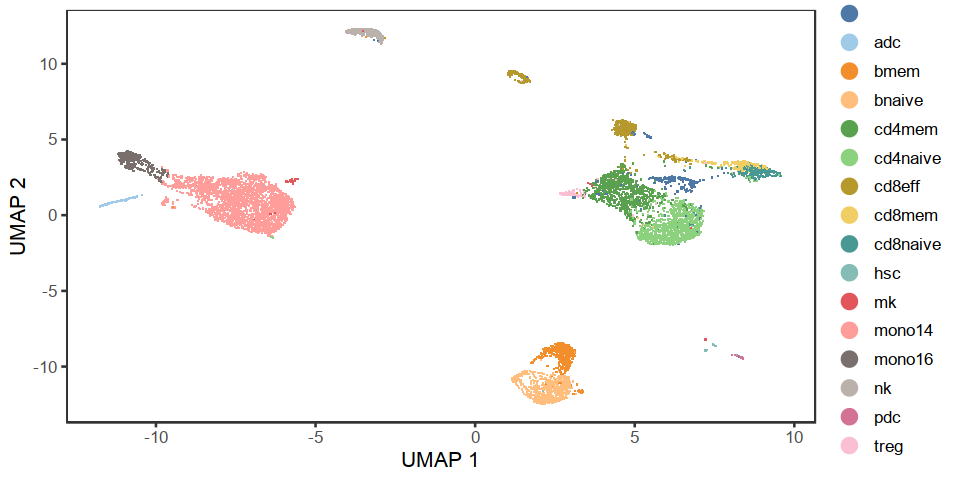

In [32]:
fig.size(4, 8)
do_scatter(umap2, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

In [88]:
dge2 <- exprs_norm[var_genes, ] %>%
    limma::lmFit(model.matrix(~ 0 + meta_data$cell_type)) %>% 
    limma::eBayes() %>%
    with(coefficients) %>% 
    data.frame() %>% 
    tibble::rownames_to_column('gene')


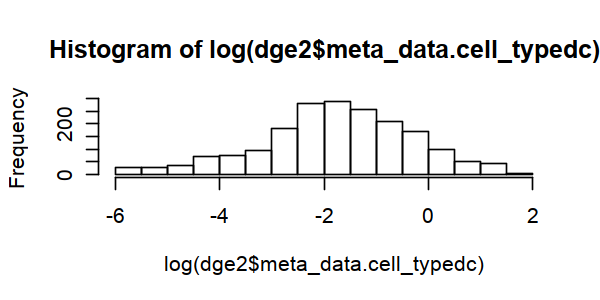

In [89]:
fig.size(2.5, 5)
hist(log(dge2$meta_data.cell_typedc))

## Local Melody

In [34]:
source('melody.R')
R <- t(model.matrix(~ 0 + meta_data$cell_type))
meta_data$depth <- log(meta_data$nUMI)
exprs_local_melody <- melody(exprs_raw[var_genes, ], meta_data, R, R_thresh=0.05, family='lm')

TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: when correcting counts, do expm1 since you already used logp1


In [35]:
pca_res <- exprs_local_melody %>% 
    log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V3 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [36]:
umap3 <- umap(V3, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

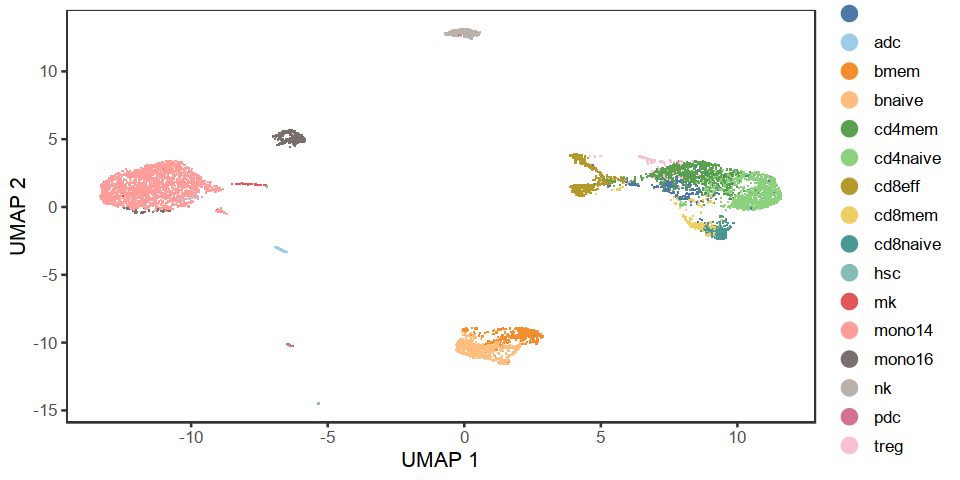

In [37]:
fig.size(4, 8)
do_scatter(umap3, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

In [68]:
dge3 <- log1p(exprs_local_melody) %>%
    limma::lmFit(model.matrix(~ 0 + meta_data$cell_type)) %>% 
    limma::eBayes() %>%
    with(coefficients) %>% 
    data.frame() %>% 
    tibble::rownames_to_column('gene')


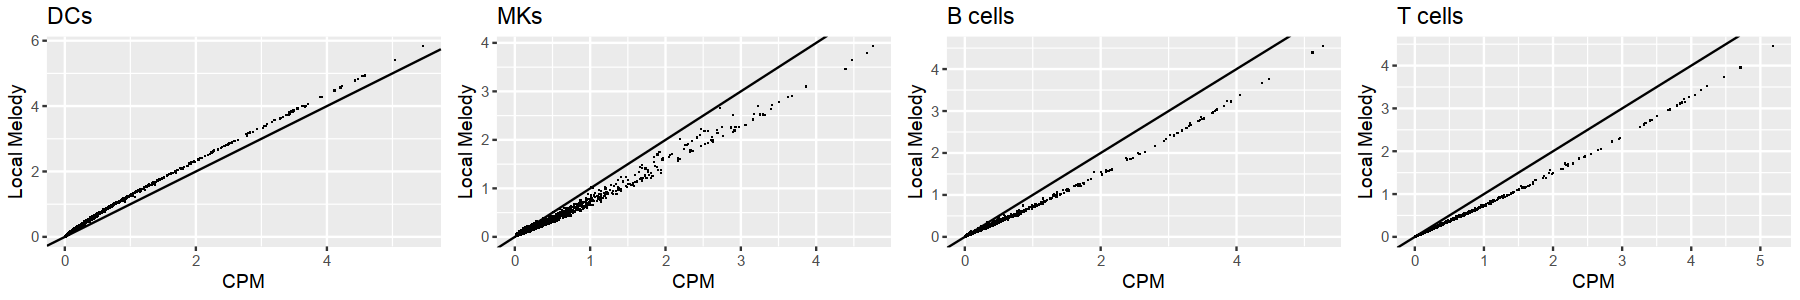

In [104]:
fig.size(2.5, 15)
dplyr::inner_join(dge2, dge3, by = 'gene', suffix = c('_cpm', '_mel')) %>% 
    ggplot(aes(meta_data.cell_typedc_cpm, meta_data.cell_typedc_mel)) + 
        geom_point(shape = '.') + 
        geom_abline(slope = 1, intercept = 0) + 
        labs(x = 'CPM', y = 'Local Melody', title = 'DCs') + 

dplyr::inner_join(dge2, dge3, by = 'gene', suffix = c('_cpm', '_mel')) %>% 
    ggplot(aes(meta_data.cell_typemk_cpm, meta_data.cell_typemk_mel)) + 
        geom_point(shape = '.') + 
        geom_abline(slope = 1, intercept = 0) + 
        labs(x = 'CPM', y = 'Local Melody', title = 'MKs') + 
dplyr::inner_join(dge2, dge3, by = 'gene', suffix = c('_cpm', '_mel')) %>% 
    ggplot(aes(meta_data.cell_typebcells_cpm, meta_data.cell_typebcells_mel)) + 
        geom_point(shape = '.') + 
        geom_abline(slope = 1, intercept = 0) + 
        labs(x = 'CPM', y = 'Local Melody', title = 'B cells') + 
dplyr::inner_join(dge2, dge3, by = 'gene', suffix = c('_cpm', '_mel')) %>% 
    ggplot(aes(meta_data.cell_typetcells_cpm, meta_data.cell_typetcells_mel)) + 
        geom_point(shape = '.') + 
        geom_abline(slope = 1, intercept = 0) + 
        labs(x = 'CPM', y = 'Local Melody', title = 'T cells') + 
plot_layout(nrow = 1)

## Global Melody

In [38]:
source('melody.R')
# R <- t(model.matrix(~ 0 + meta_data$cell_type))
R <- matrix(rep(1, nrow(meta_data)), nrow = 1)
meta_data$depth <- log(meta_data$nUMI)
exprs_global_melody <- melody(exprs_raw[var_genes, ], meta_data, R, R_thresh=0.05, family='lm')

TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: when correcting counts, do expm1 since you already used logp1


In [39]:
pca_res <- exprs_global_melody %>% 
    log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V4 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [40]:
umap4 <- umap(V4, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

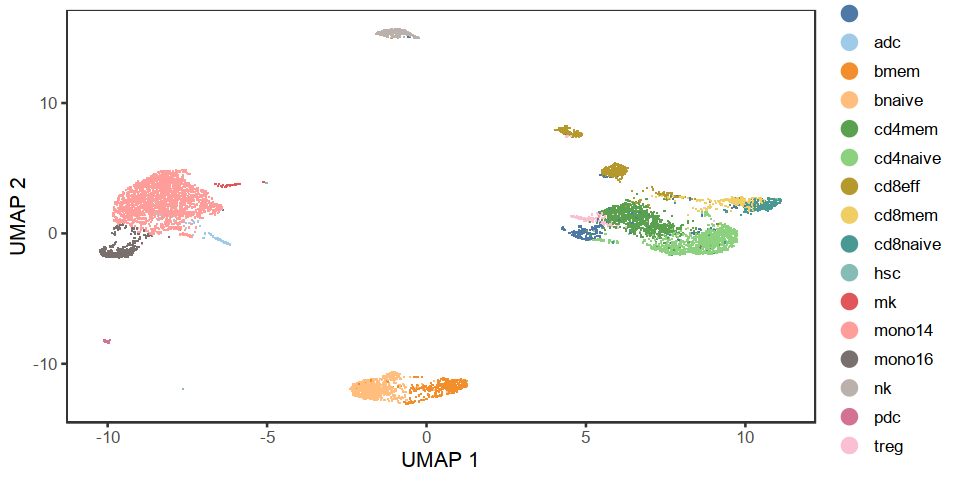

In [41]:
fig.size(4, 8)
do_scatter(umap4, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

## Local Melody (subtypes)

In [134]:
source('melody.R')
R <- t(model.matrix(~ 0 + meta_data$cell_subtype))
meta_data$depth <- log(meta_data$nUMI)
exprs_local_melody2 <- melody(exprs_raw[var_genes, ], meta_data, R, R_thresh=0.05, family='lm')

TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix this in next iteration.
TODO: design matrix is hard coded right now. Fix th

In [135]:
pca_res <- exprs_local_melody2 %>% 
    log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V5 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [136]:
umap5 <- umap(V5, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

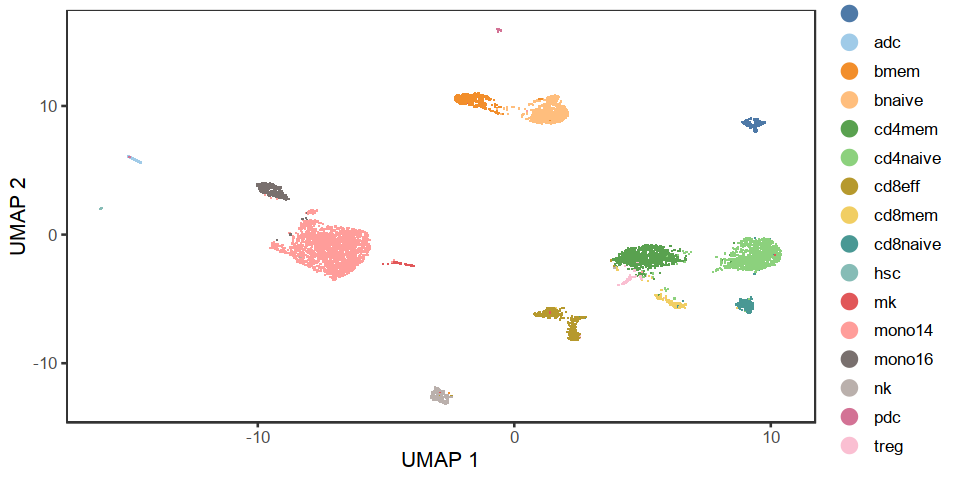

In [137]:
fig.size(4, 8)
do_scatter(umap5, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

In [138]:
dge5 <- log1p(exprs_local_melody2) %>%
    limma::lmFit(model.matrix(~ 0 + meta_data$cell_type)) %>% 
    limma::eBayes() %>%
    with(coefficients) %>% 
    data.frame() %>% 
    tibble::rownames_to_column('gene')


## Sctransform (poisson)

    with or without smoothing

In [243]:
library(sctransform)
system.time({
    suppressWarnings({
        sct_res <- sctransform::vst(
            exprs_raw[var_genes, ],
            method = 'poisson',
            do_regularize = FALSE, 
            return_cell_attr = TRUE,
            return_corrected_umi = TRUE
        )
    })    
})


Calculating cell attributes for input UMI matrix
do_regularize is set to FALSE, will use all genes
Variance stabilizing transformation of count matrix of size 2000 by 7697
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 2000 genes, 7697 cells


  |======================================================================| 100%


Second step: Get residuals using fitted parameters for 2000 genes


  |======================================================================| 100%


Computing corrected count matrix for 2000 genes


  |======================================================================| 100%


Calculating gene attributes
Wall clock passed: Time difference of 3.235688 mins


   user  system elapsed 
296.685   2.339 194.582 

In [244]:
pca_res <- sct_res$y %>% 
#     log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V6 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [245]:
umap6 <- umap(V6, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

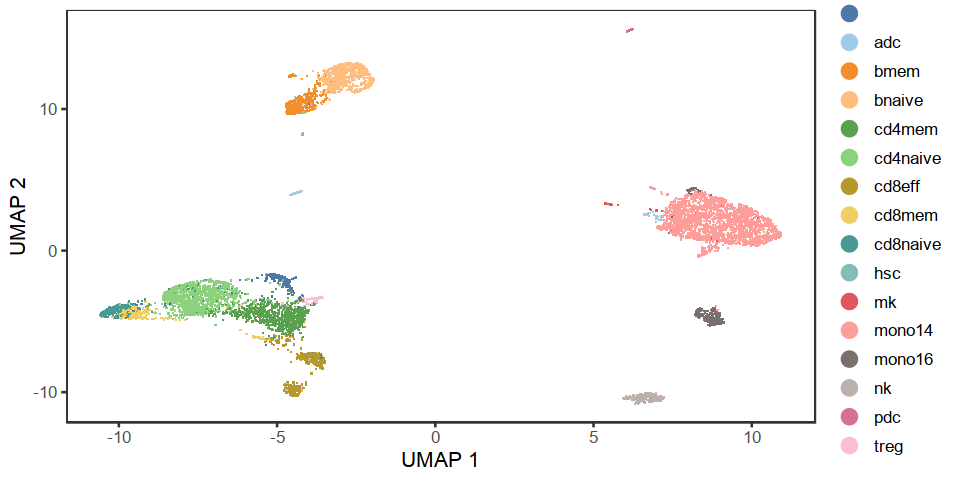

In [246]:
fig.size(4, 8)
do_scatter(umap6, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

## Local Melody (poisson)

In [237]:
source('melody.R')
R <- t(model.matrix(~ 0 + meta_data$cell_type))
meta_data$depth <- log(meta_data$nUMI)
suppressWarnings({
    exprs_local_melody_poisson <- melody(exprs_raw[var_genes, ], meta_data, R, R_thresh=0.05, family='poisson')
})
    

TODO: when correcting counts, do expm1 since you already used logp1


In [238]:
pca_res <- exprs_local_melody_poisson %>% 
    log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V7 <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [239]:
umap7 <- umap(V7, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

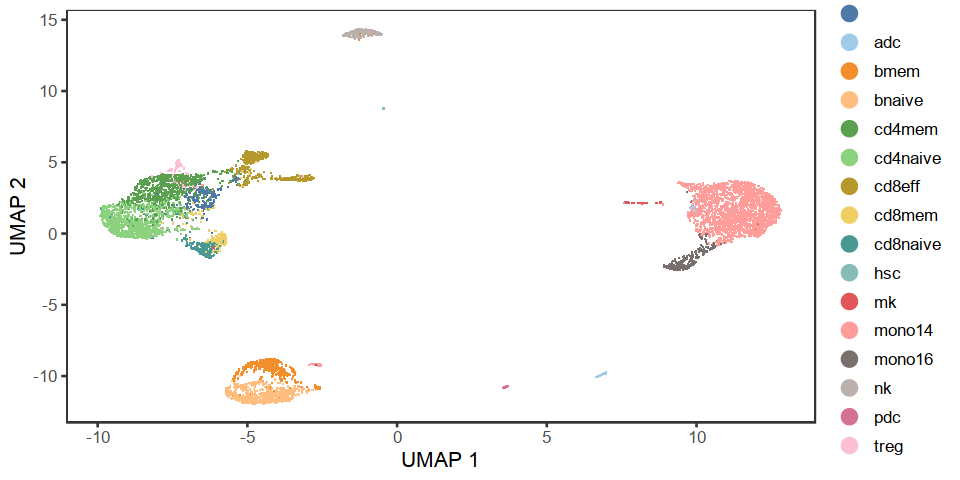

In [240]:
fig.size(4, 8)
do_scatter(umap7, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

# Marker comparison

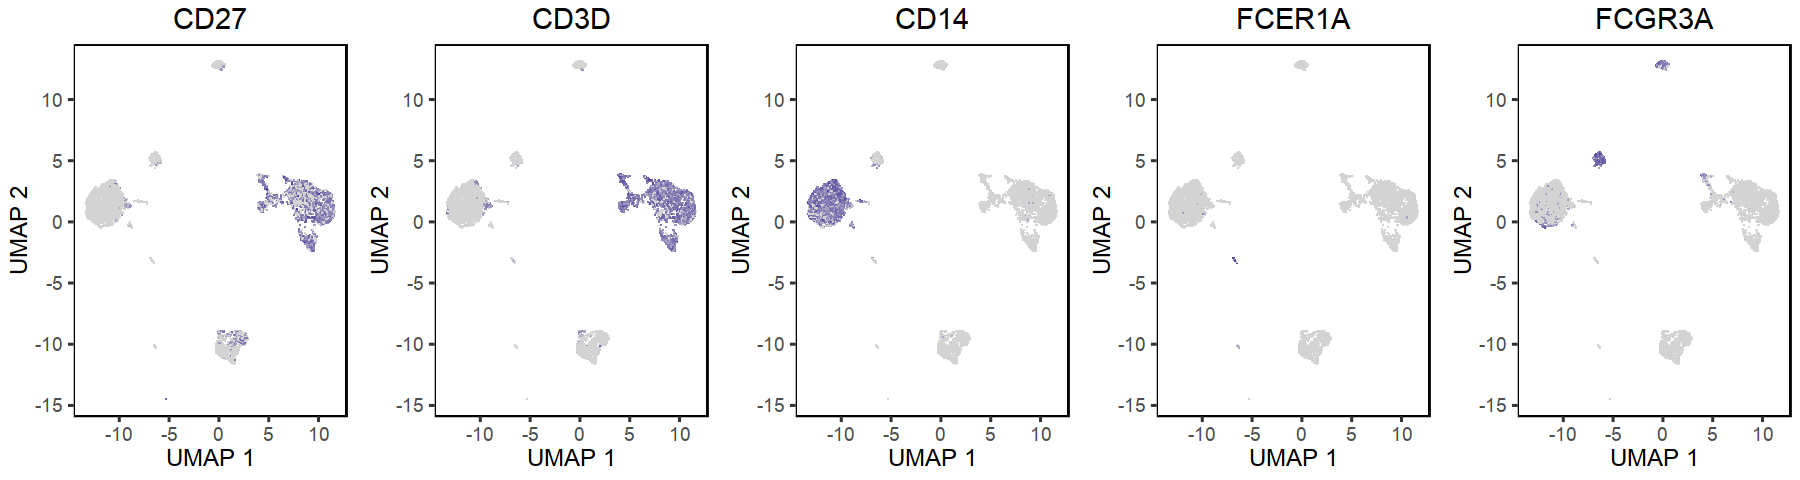

In [58]:
fig.size(4, 15)
plotFeatures(exprs_norm, umap3, c('CD27', 'CD3D', 'CD14', 'FCER1A', 'FCGR3A'), no_guide = TRUE, pt_shape = '.')


In [241]:
fig.size(4, 15)
plotFeatures(log1p(exprs_local_melody), umap3, c('CD27', 'CD3D', 'CD14', 'FCER1A', 'FCGR3A'), no_guide = TRUE, pt_shape = '.')


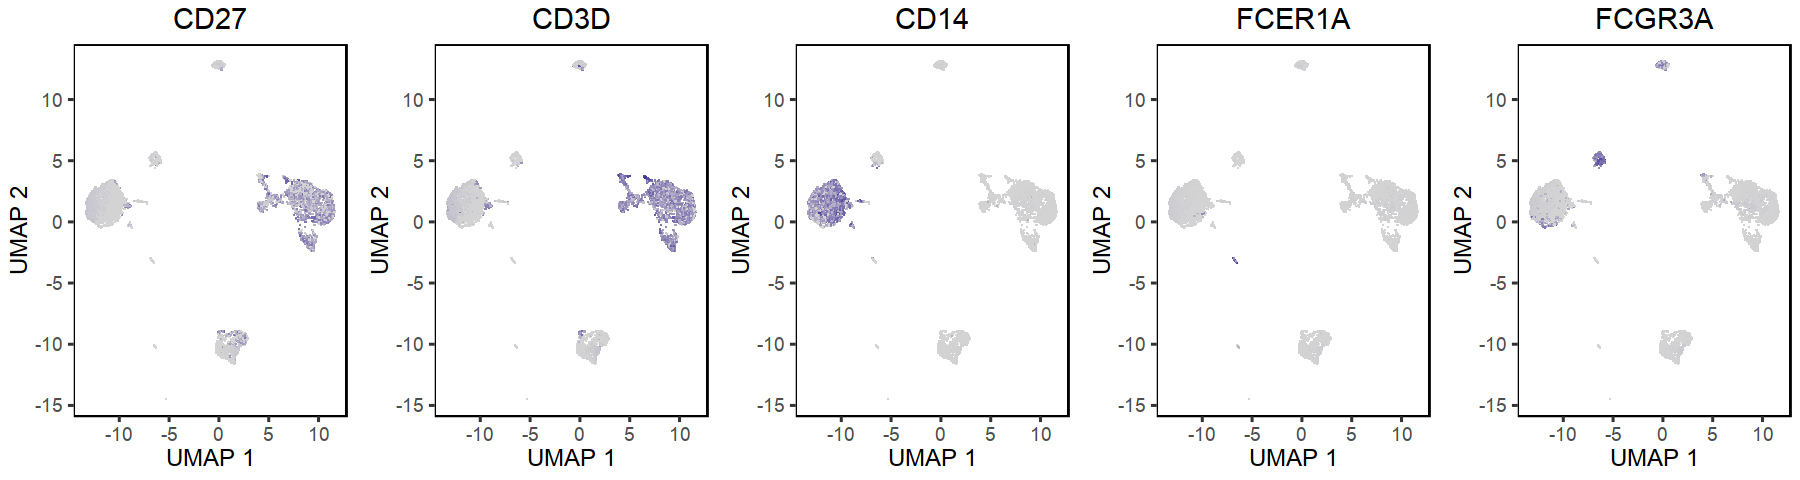

In [57]:
fig.size(4, 15)
plotFeatures(log1p(exprs_global_melody), umap3, c('CD27', 'CD3D', 'CD14', 'FCER1A', 'FCGR3A'), no_guide = TRUE, pt_shape = '.')


# Independence from nUMI

In [141]:
x <- data.table(
    raw = cor(V1, log(meta_data$nUMI)), 
    cpm = cor(V2, log(meta_data$nUMI)), 
    local = cor(V3, log(meta_data$nUMI)), 
    local2 = cor(V5, log(meta_data$nUMI)), 
    global = cor(V4, log(meta_data$nUMI))
)

colSums(x^2)


raw.V1    cpm.V1  local.V1 local2.V1 global.V1 
0.9549092 0.7862732 0.3702149 0.4950966 0.3718118

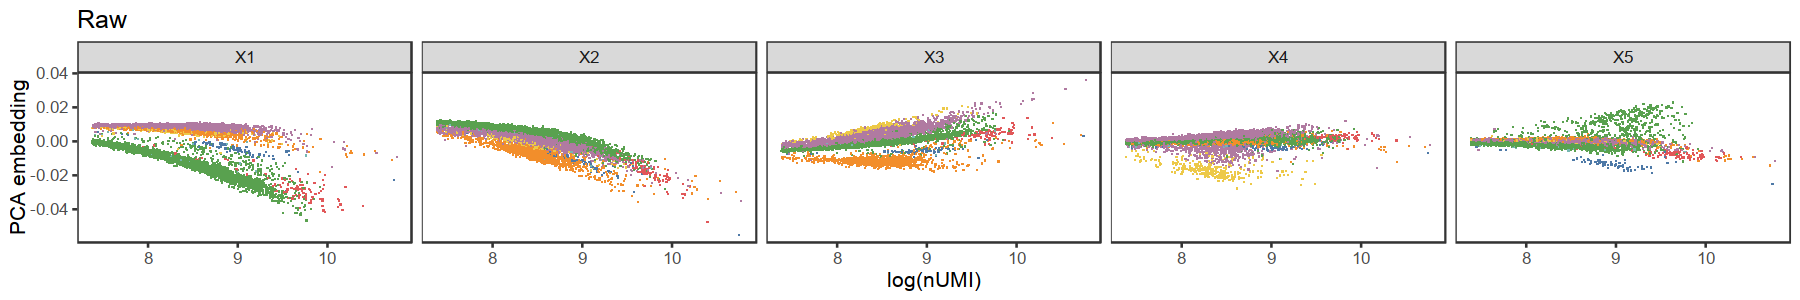

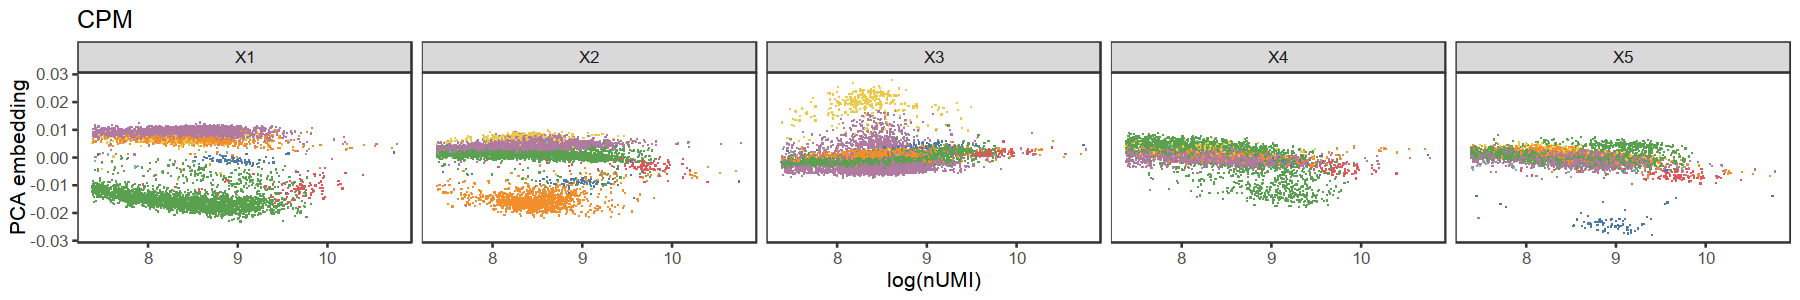

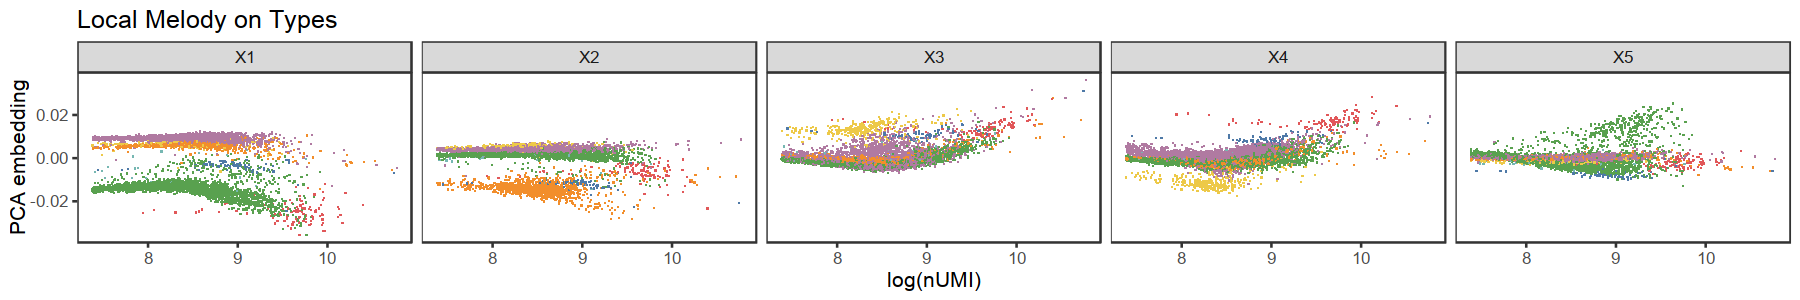

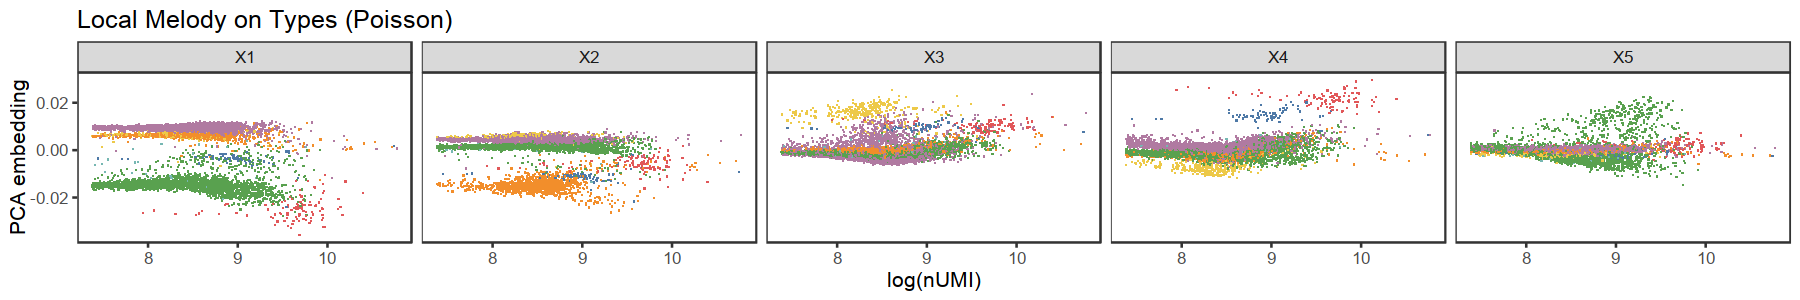

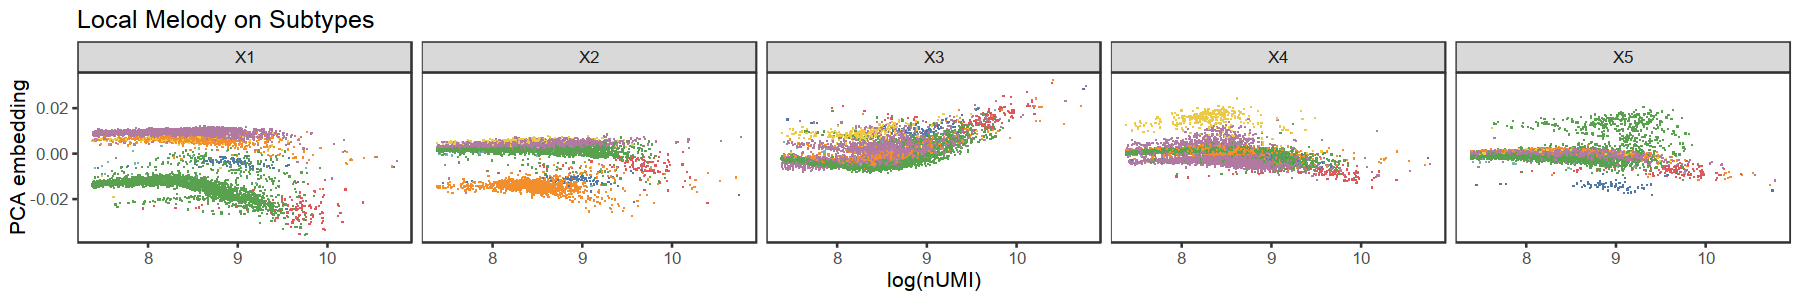

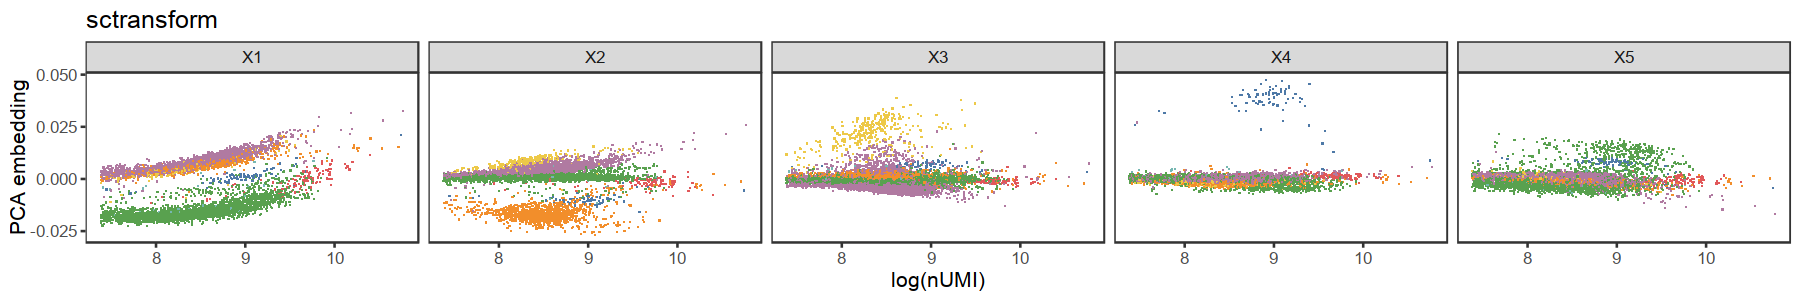

In [247]:
fig.size(2.5, 15)
foo <- function(V) {
    V %>% data.frame() %>%
        cbind(meta_data) %>% 
        tidyr::gather(key, val, X1:X20) %>% 
        subset(key %in% paste0('X', 1:5)) %>% 
        dplyr::sample_frac(1L, FALSE) %>% 
        ggplot(aes(log(nUMI), val, color = cell_type)) + 
            geom_point(shape = '.') + 
            facet_wrap(~key, nrow = 1) + 
            scale_color_tableau() + guides(color = FALSE) + 
            theme_test(base_size = 12) + 
            labs(y = 'PCA embedding')
}
foo(V1) + labs(title = 'Raw')
foo(V2) + labs(title = 'CPM')
foo(V3) + labs(title = 'Local Melody on Types')
foo(V7) + labs(title = 'Local Melody on Types (Poisson)')
foo(V5) + labs(title = 'Local Melody on Subtypes')
foo(V6) + labs(title = 'sctransform')
# foo(V4)


# Smoothing makes a big difference in sctransform

## Smoothed poisson

In [248]:
library(sctransform)
system.time({
    suppressWarnings({
        sct_res_smooth <- sctransform::vst(
            exprs_raw[var_genes, ],
            method = 'poisson',
            do_regularize = TRUE, 
            return_cell_attr = TRUE,
            return_corrected_umi = TRUE
        )
    })    
})


Calculating cell attributes for input UMI matrix
Variance stabilizing transformation of count matrix of size 2000 by 7697
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 2000 genes, 7697 cells


  |======================================================================| 100%


Found 2 outliers - those will be ignored in fitting/regularization step

Second step: Get residuals using fitted parameters for 2000 genes


  |======================================================================| 100%


Computing corrected count matrix for 2000 genes


  |======================================================================| 100%


Calculating gene attributes
Wall clock passed: Time difference of 3.327213 mins


   user  system elapsed 
305.761   1.365 200.028 

In [249]:
pca_res <- sct_res_smooth$y %>% 
#     log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V_smooth <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [250]:
umap_smooth <- umap(V_smooth, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

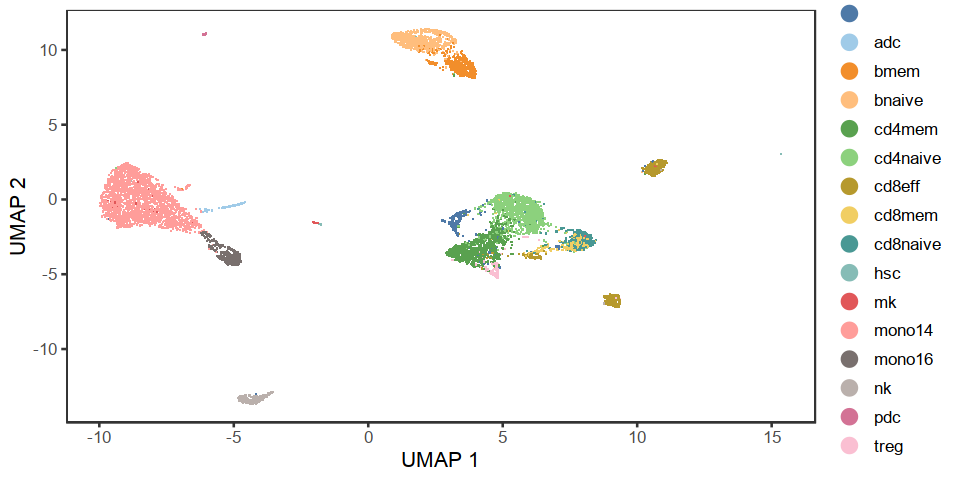

In [251]:
fig.size(4, 8)
do_scatter(umap_smooth, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

## Un-Smoothed poisson

In [253]:
library(sctransform)
system.time({
    suppressWarnings({
        sct_res_noSmooth <- sctransform::vst(
            exprs_raw[var_genes, ],
            method = 'poisson',
            do_regularize = FALSE, 
            return_cell_attr = TRUE,
            return_corrected_umi = TRUE
        )
    })    
})


Calculating cell attributes for input UMI matrix
do_regularize is set to FALSE, will use all genes
Variance stabilizing transformation of count matrix of size 2000 by 7697
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 2000 genes, 7697 cells


  |======================================================================| 100%


Second step: Get residuals using fitted parameters for 2000 genes


  |======================================================================| 100%


Computing corrected count matrix for 2000 genes


  |======================================================================| 100%


Calculating gene attributes
Wall clock passed: Time difference of 3.1362 mins


   user  system elapsed 
290.785   1.227 188.565 

In [254]:
pca_res <- sct_res_noSmooth$y %>% 
#     log1p() %>% 
    singlecellmethods::scaleData(1) %>%
    rARPACK::svds(20, 0, 20)
V_noSmooth <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")

In [255]:
umap_noSmooth <- umap(V_noSmooth, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)

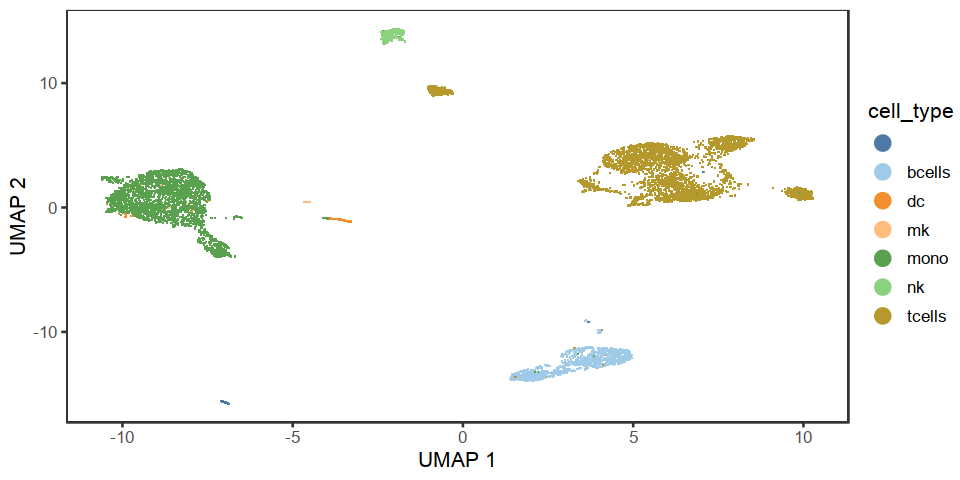

In [258]:
fig.size(4, 8)
# do_scatter(umap_noSmooth, meta_data, "cell_subtype", pt_size = 3, no_guides = FALSE, 
#                           palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
do_scatter(umap_noSmooth, meta_data, "cell_type", pt_size = 3, no_guides = FALSE, 
                          palette_use = tableau_color_pal('Tableau 20')(18), do_labels = FALSE) + 
NULL

## Smoothing removes more correlation with nUMI (esp in high nUMI cells)

In fact, it actually creates correlation for some cell types that wasn't there before. 

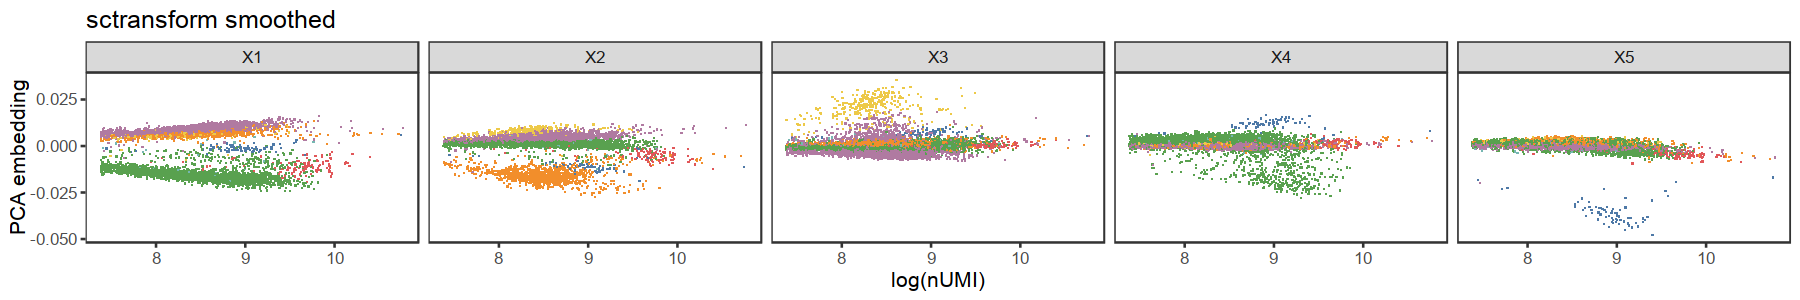

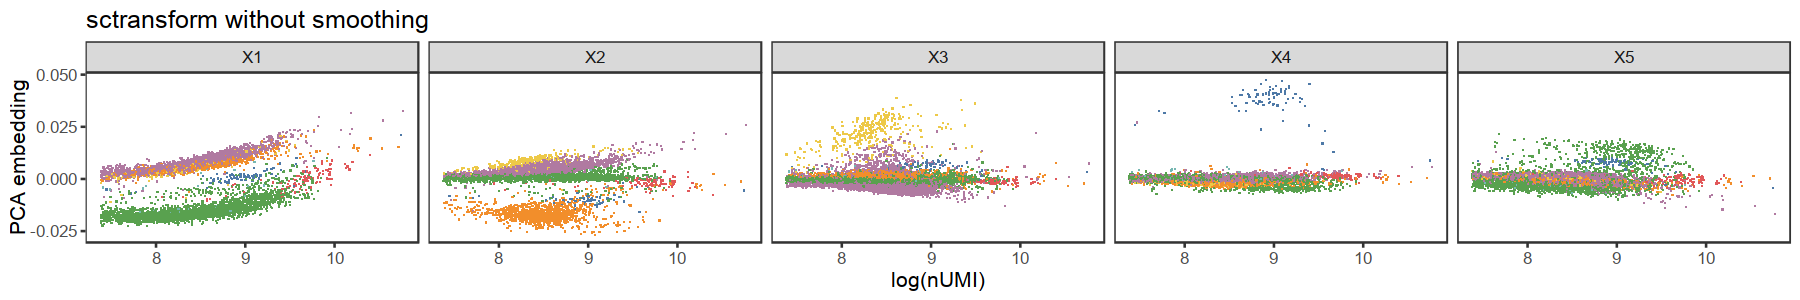

In [257]:
fig.size(2.5, 15)
foo <- function(V) {
    V %>% data.frame() %>%
        cbind(meta_data) %>% 
        tidyr::gather(key, val, X1:X20) %>% 
        subset(key %in% paste0('X', 1:5)) %>% 
        dplyr::sample_frac(1L, FALSE) %>% 
        ggplot(aes(log(nUMI), val, color = cell_type)) + 
            geom_point(shape = '.') + 
            facet_wrap(~key, nrow = 1) + 
            scale_color_tableau() + guides(color = FALSE) + 
            theme_test(base_size = 12) + 
            labs(y = 'PCA embedding')
}
foo(V_smooth) + labs(title = 'sctransform smoothed')
foo(V_noSmooth) + labs(title = 'sctransform without smoothing')
# foo(V4)


# Does smoothing have the same effect with a Gaussian error model? 

# Quantify how much nUMI-based variance explained remains after each case